### Overview

Google Earth Engine (GEE) is a cloud-based platform that has a large public data catalog and computing infrastructure. The [XEE](https://github.com/google/Xee) extension makes it possible to obtain pre-processed data cube directly from GEE as a XArray Dataset. In this section, we will learn how to process the GEE data using XArray and Dask on local compute infrastructure using the time-series processing capabilities of XArray.

We will obtain a datacube of cloud-masked Sentinel-2 images for a year over a chosen region and apply temporal aggregation to obtain mean monthly NDVI images.

*Note: You must have a Google Earth Engine account to complete this section. If you do not have one, [follow our guide](https://courses.spatialthoughts.com/gee-sign-up.html) to sign up.*

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
    !pip install rioxarray

In [ ]:

import ee
import xarray
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np

In [ ]:
output_folder = 'output'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

We initialize Google Earth Engine API.You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/). Here we are using the [High Volume Endpoint](https://developers.google.com/earth-engine/cloud/highvolume) which is recommended when working with XEE.

In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')

### Data Pre-Processing

We start with the Sentinel-2 collection, apply a cloud mask and compute NDVI using the Google Earth Engine API.

In [ ]:
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
geometry = ee.Geometry.Polygon([[
  [82.60642647743225, 27.16350437805251],
  [82.60984897613525, 27.1618529901377],
  [82.61088967323303, 27.163695288375266],
  [82.60757446289062, 27.16517483230927]
]])

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry))

# Write a function for Cloud masking
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).multiply(0.0001) \
      .select('B.*') \
      .copyProperties(image, ['system:time_start'])

filtered = filtered.map(maskS2clouds)
# Write a function that computes NDVI for an image and adds it as a band
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

# Map the function over the collection
withNdvi = filtered.map(addNDVI)

Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the 'ee' engine.

`scale` in XEE behaves differently than in GEE API. The value of the `scale` is in the units of the CRS. So to get the data at 10 meters resolution, we must also specify a CRS that has the unit of meters.

In [ ]:
ds = xarray.open_dataset(
    withNdvi.select('ndvi'),
    engine='ee',
    crs='EPSG:3857',
    scale=10,
    geometry=geometry,
)

In [ ]:
ds

Since we want to work with coordinates in latitude and longitude, we reproject the raster to `EPSG:4326`. This requires renaming and reordering the dimentions to those expected by rioxarray.

In [ ]:
ds_reprojected = ds\
  .rename({'Y': 'y', 'X': 'x'}) \
  .transpose('time', 'y', 'x') \
  .rio.reproject('EPSG:4326')
ds_reprojected

Select the `ndvi` variable. Split the datacube into 'chunks' to allow parallel processing using Dask.

In [ ]:
original_time_series = ds_reprojected.ndvi.chunk('auto')
original_time_series

### Aggregating the Time-Series

We have a irregular time-series with a lot of noise. Let's create a monthly NDVI time-series by computing the monthly average NDVI. We can use XArray's `resample()` method to aggregate the time-series by Months and coompute the mean. We specify *time* as `MS` to indicate aggregating by month start and *label* as `left` to indicate we want the start of the month as our series labels.

Reference [Pandas Offset Aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [ ]:
time_series_aggregated = original_time_series.resample(time='MS', label='left').mean()
time_series_aggregated

Plot and Extract the Time-Series at a Single Location

In [ ]:
original_ts = original_time_series.interp(x=82.607376, y=27.164335).compute()
aggregated_ts = time_series_aggregated.interp(x=82.607376, y=27.164335).compute()

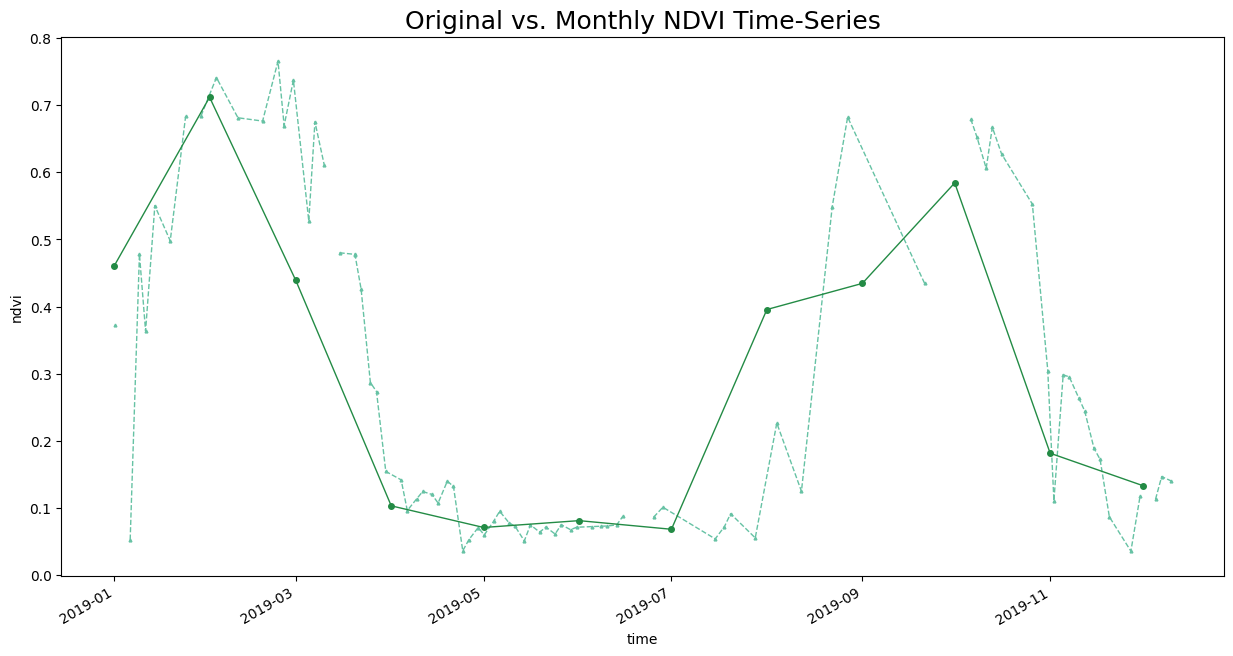

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
aggregated_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)

ax.set_title('Original vs. Monthly NDVI Time-Series', size = 18)

plt.show()

### Downloading Time-Series Images

Save the processed monthly NDVI images using `rioxarray` as GeoTIFF files.

In [ ]:
for time in time_series_aggregated.time.values:
  image = time_series_aggregated.sel(time=time)
  date = np.datetime_as_string(time, unit='M')
  output_file = f'{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')
  print(f'Created file at {output_path}')

### Exercise

Aggregate the time-series to 15-day interval. Apply gap-filling to fill missing values.

*Hint: Refer to Reference [Pandas Offset Aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for appropriate string value for the time parameter.*